**Adding libraries and dependencies**

In [72]:
import numpy as np
import tensorflow as tf

from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel
from mlagents_envs.base_env import ActionTuple
from collections import deque

import tf_agents
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.networks import q_network
from tf_agents.agents.dqn import dqn_agent
from tf_agents.utils import common
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import array_spec
from tf_agents.policies import policy_saver

import matplotlib.pyplot as plt

Checking GPU detection

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-08-14 16:10:56.015565: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-14 16:10:56.063709: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-14 16:10:56.063765: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


**Establishing connection with Unity environment**

In [159]:
env.close()

In [160]:
engine_config_channel = EngineConfigurationChannel()

env = UnityEnvironment(
    file_name=None,
    worker_id=0,
    base_port=5004,
    side_channels=[engine_config_channel]
)

In [161]:
env.reset()
behavior_names = list(env.behavior_specs)
behavior_name = behavior_names[0]
behavior_spec = env.behavior_specs[behavior_name]

print(f"Behavior: {behavior_name}")
print(f"Action branches: {behavior_spec.action_spec.discrete_branches}")
print(f"Observation shapes: {[obs.shape for obs in behavior_spec.observation_specs]}")

decision_steps, terminal_steps = env.get_steps(behavior_name)
print(f"Active agents: {len(decision_steps)}")

Behavior: RobotBehaviour?team=0
Action branches: (5,)
Observation shapes: [(45,), (10,)]
Active agents: 1


### Action Space
- **5 discrete actions** corresponding to possible movements:
  - `0`: Do nothing
  - `1`: Go right  
  - `2`: Go left
  - `3`: Go forward
  - `4`: Go backwards

### Observation Space

#### Ray Perception (45 dimensions)
- **45 values** from ML-Agents Ray Perception Sensor 3D component
- Detects tags and distances in the environment. It detects the tags: Floor, GoodSphere, Badsphere. The Sensor contains 9 rays, each contains these following 5 observations:
  - Floor: `0` not detected, `1` detected
  - GoodSphere: `0` not detected, `1` detected
  - BadSphere: `0` not detected, `1` detected
  - Distance: varies from `0`(far) to `1`(close)
  - Hit normal: Surface normal vector at the point where the ray intersects with the object (normalized)

#### Agent State (10 dimensions)
- **10 normalized values** divided as follows:
  - Position: `x`, `z` coordinates
  - Velocity: `x`, `z` velocity components  
  - Rotation: `y`-axis rotation (facing direction)
  - Distances to floor bounds: `top`, `bottom`, `right`, `left` 
  - Time: Elapsed time since episode start

**Total observation size:** 55

---

In [141]:
action_size = 5
state_size = 55

Preparing a get_state function for model training and inference, that is responsible for getting the agent's state at the current step and returning information which will later be used by the model :
- state (55,) : agent's state at the current step
- reward (float) : reward of the current step
- done (boolean) : whether the episode is terminated at the current step

In [142]:
def get_state():
    decision_steps, terminal_steps = env.get_steps(behavior_name)
    
    if len(decision_steps) > 0:
        obs1 = decision_steps.obs[0][0] #Ray perception sensor observations
        obs2 = decision_steps.obs[1][0] #Agent state observations
        state = np.concatenate([obs1, obs2]) #Combine observations for correct DQN input format
        return state, decision_steps.reward[0], False
    
    elif len(terminal_steps) > 0:
        # Episode ended
        obs1 = terminal_steps.obs[0][0]
        obs2 = terminal_steps.obs[1][0] 
        state = np.concatenate([obs1, obs2])
        return state, terminal_steps.reward[0], True
    
    return None, 0, False


**Making a random Neural Network**

In [143]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(state_size,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(action_size, activation='linear')
])

In [144]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_85 (Dense)            (None, 256)               14336     
                                                                 
 dense_86 (Dense)            (None, 512)               131584    
                                                                 
 dense_87 (Dense)            (None, 256)               131328    
                                                                 
 dense_88 (Dense)            (None, 128)               32896     
                                                                 
 dense_89 (Dense)            (None, 5)                 645       
                                                                 
Total params: 310789 (1.19 MB)
Trainable params: 310789 (1.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [145]:
l1_weights = model.get_weights()[0]
l1_weights[:,0] #weights of the first neuron of the first layer

array([ 0.13750727,  0.00921607,  0.03249387,  0.07085869, -0.03566846,
        0.05218567, -0.02091374, -0.02513511,  0.07827139,  0.07110067,
        0.13165237, -0.04992564, -0.09733048,  0.05739731, -0.03092451,
       -0.04039246, -0.12494984,  0.00405794,  0.03127687,  0.03236151,
       -0.01069216,  0.02104722, -0.12931222,  0.04634036,  0.07652424,
       -0.0891984 ,  0.03692609, -0.09307221,  0.02865909,  0.08901645,
        0.03213388,  0.07909602,  0.00285971, -0.05333754, -0.11070258,
       -0.0636193 ,  0.08487228, -0.11352024,  0.10623053,  0.1303613 ,
       -0.07430696, -0.02079445,  0.08171985, -0.0742671 ,  0.13154258,
        0.13719131,  0.09895338,  0.02390234,  0.00431363, -0.02783852,
       -0.09801717,  0.12024151,  0.0356047 ,  0.05814715, -0.08808   ],
      dtype=float32)

Running the model with the initial random weights

In [146]:
for step in range(100): #Run for 100 steps
    state, reward, done = get_state()
    
    if state is not None:
        if done:
            env.reset()
        q_values = model.predict(np.expand_dims(state, axis=0), verbose=0)
        action = np.argmax(q_values[0])  # Choose best action
        
        if step % 10 == 0: 
            print(f"Step {step}: Action {action}, Reward {reward:.2f}")
        
        # Send action to Unity
        action_tuple = ActionTuple(discrete=np.array([[action]]))
        env.set_actions(behavior_name, action_tuple)
        env.step()
    else:
        env.close()
    

Step 0: Action 2, Reward 0.00
Step 10: Action 2, Reward 0.00
Step 20: Action 2, Reward 0.00
Step 30: Action 2, Reward 0.00
Step 40: Action 2, Reward 0.00
Step 50: Action 2, Reward 0.00
Step 60: Action 2, Reward 0.00
Step 70: Action 2, Reward 0.00
Step 80: Action 2, Reward 0.00
Step 90: Action 2, Reward 0.00


**Creating environment wrapper for TF agents**

In [147]:
class EnvironmentWrapper(py_environment.PyEnvironment):
    def __init__(self, unity_env, behavior_name):
        super().__init__()
        self.unity_env = unity_env
        self.behavior_name = behavior_name
        
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(),
            dtype=np.int32,
            minimum=0,
            maximum=4,
            name='action'
        )
        self._observation_spec = array_spec.ArraySpec(
            shape=(state_size,),
            dtype=np.float32,
            name='observation'
        )

        self._state = np.zeros(state_size, dtype=np.float32)
        self._episode_ended = False

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self.unity_env.reset()
        self._episode_ended = False
        state, _, _ = get_state()
        if state is not None:
            self._state = state.astype(np.float32)
        return tf_agents.trajectories.time_step.restart(self._state)

    def _step(self, action):
        if self._episode_ended:
            return self.reset()
        
        # Send action to Unity
        action_tuple = ActionTuple(discrete=np.array([[action]]))
        self.unity_env.set_actions(self.behavior_name, action_tuple)
        self.unity_env.step()
        
        # Get new state
        state, reward, done = get_state()
        
        if state is not None:
            self._state = state.astype(np.float32)
        
        if done:
            self._episode_ended = True
            return tf_agents.trajectories.time_step.termination(self._state, reward)
        else:
            return tf_agents.trajectories.time_step.transition(self._state, reward)

In [162]:
env_wrapper = EnvironmentWrapper(env, behavior_name)
tf_env = tf_py_environment.TFPyEnvironment(env_wrapper)

**Setting the architecture of the Q-neural-networks**

In [149]:
q_net = q_network.QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    fc_layer_params=(256, 512, 256, 128)
)

**Creating the agent (Deep-Q-Network)**

In [150]:
train_step_counter = tf.Variable(0)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter,
    epsilon_greedy=0.1,
    target_update_period=100,
    gamma=0.99 
)

agent.initialize()

**Creating the replay buffer**

In [151]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=100000
)

**Creating policies**

In [152]:
eval_policy = agent.policy # greedy: for testing and inference
collect_policy = agent.collect_policy # Epsilon-greedy: for training and exploration
random_policy = random_tf_policy.RandomTFPolicy(  # Completely random: for initial data collection
    tf_env.time_step_spec(), 
    tf_env.action_spec()
)

**Data collection**

In [157]:
def collect_data(policy, steps, speed, replay_buffer):
    engine_config_channel.set_configuration_parameters(time_scale=speed)
    tf_env.reset()
    for i in range(steps):
        time_step = tf_env.current_time_step()
        action_step = policy.action(time_step)
        next_time_step = tf_env.step(action_step.action)
        traj = trajectory.from_transition(time_step, action_step, next_time_step)
        replay_buffer.add_batch(traj)
        if i % 100 == 0 and i > 0:
            print(f"Collected {i} steps")

### **Training the model**
**1<sup>st</sup> round of training**
During this round, the agent learns not to fall. We remove the items from the environment and we change the reward like this:
- Falling : -100
- Doing nothing : -50 (to encourage the agent to learn to move without falling)

Collecting initial data randomly

In [163]:
#clearing the replay buffer in case it has some experiments from previous collections
replay_buffer.clear()

In [164]:
collect_data(random_policy, 1000, 5, replay_buffer)

Collected 100 steps
Collected 200 steps
Collected 300 steps
Collected 400 steps
Collected 500 steps
Collected 600 steps
Collected 700 steps
Collected 800 steps
Collected 900 steps


In [165]:
num_iterations = 10000
collect_steps_per_iteration = 4
batch_size = 64
eval_interval = 200

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2
).prefetch(3)

iterator = iter(dataset)

In [166]:
train_losses = []
episode_returns = []

for iteration in range(num_iterations):
    #collect data for 4 steps
    collect_data(collect_policy, collect_steps_per_iteration, 100, replay_buffer)

    # Sample a random batch from the replay buffer and train the agent
    experience, _ = next(iterator)
    train_loss = agent.train(experience).loss
    
    training_step = agent.train_step_counter.numpy()

    # Log and evaluate each 200 training step
    if training_step % eval_interval == 0:
        print(f'Training step {training_step}: Loss = {train_loss:.4f} | Env step = {iteration * collect_steps_per_iteration}')
        train_losses.append(train_loss.numpy())
        
        engine_config_channel.set_configuration_parameters(time_scale=1)
        time_step = tf_env.reset()
        episode_return = 0.0
        steps_in_episode = 0

        while not time_step.is_last() and steps_in_episode < 500:
            action_step = eval_policy.action(time_step)
            time_step = tf_env.step(action_step.action)
            episode_return += time_step.reward
            steps_in_episode += 1
            
        episode_returns.append(episode_return.numpy()[0])
        print(f'Evaluation episode Return: {episode_return.numpy()[0]:.2f}')

print("Training complete")

Training step 200: Loss = 0.7196 | Env step = 796
Evaluation episode Return: -100.00
Training step 400: Loss = 0.5428 | Env step = 1596
Evaluation episode Return: 0.00
Training step 600: Loss = 0.5635 | Env step = 2396
Evaluation episode Return: -100.00
Training step 800: Loss = 0.1308 | Env step = 3196
Evaluation episode Return: -100.00
Training step 1000: Loss = 0.0667 | Env step = 3996
Evaluation episode Return: -100.00
Training step 1200: Loss = 0.0141 | Env step = 4796
Evaluation episode Return: -100.00
Training step 1400: Loss = 0.4820 | Env step = 5596
Evaluation episode Return: -100.00
Training step 1600: Loss = 0.0545 | Env step = 6396
Evaluation episode Return: -100.00
Training step 1800: Loss = 0.0560 | Env step = 7196
Evaluation episode Return: -100.00
Training step 2000: Loss = 0.0557 | Env step = 7996
Evaluation episode Return: -100.00
Training step 2200: Loss = 0.0395 | Env step = 8796
Evaluation episode Return: -100.00
Training step 2400: Loss = 0.0976 | Env step = 9596

Visualizing training information

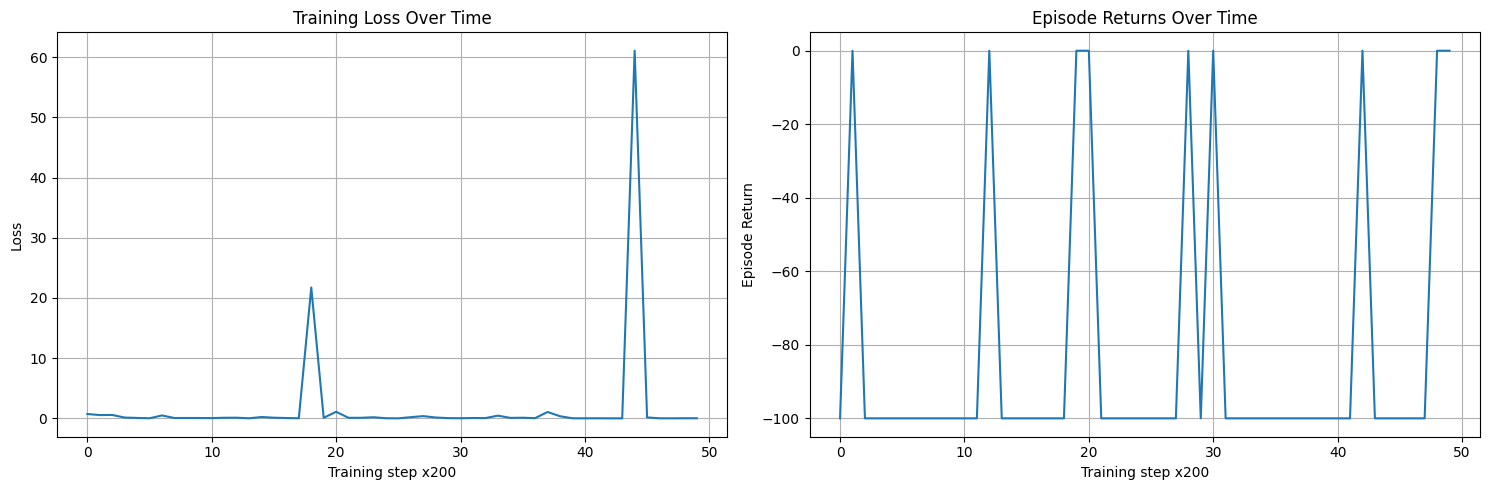

In [167]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses)
ax1.set_title('Training Loss Over Time')
ax1.set_xlabel('Training step x200')
ax1.set_ylabel('Loss')
ax1.grid(True)

ax2.plot(episode_returns)
ax2.set_title('Episode Returns Over Time')
ax2.set_xlabel('Training step x200')
ax2.set_ylabel('Episode Return')
ax2.grid(True)

plt.tight_layout()
plt.show()

Running evaluation episodes

In [168]:
total_returns = []
total_steps = []

engine_config_channel.set_configuration_parameters(time_scale=1)
for episode in range(10):
    time_step = tf_env.reset()
    episode_return = 0.0
    steps_in_episode = 0

    while not time_step.is_last():
        action_step = eval_policy.action(time_step)
        time_step = tf_env.step(action_step.action)
        episode_return += time_step.reward
        steps_in_episode += 1
    
    total_returns.append(episode_return.numpy()[0])
    total_steps.append(steps_in_episode)
    print(f"Episode {episode+1}: Return = {episode_return.numpy()[0]:.2f}, Steps = {steps_in_episode}")

avg_return = np.mean(total_returns)
avg_steps = np.mean(total_steps)
std_return = np.std(total_returns)

print(f"Average Return: {avg_return:.2f}")
print(f"Average Episode Length: {avg_steps:.1f} steps")
print(f"Best Episode: {max(total_returns):.2f}")
print(f"Worst Episode: {min(total_returns):.2f}")

Episode 1: Return = 0.00, Steps = 400
Episode 2: Return = 0.00, Steps = 400
Episode 3: Return = 0.00, Steps = 400
Episode 4: Return = 0.00, Steps = 400
Episode 5: Return = 0.00, Steps = 400
Episode 6: Return = 0.00, Steps = 400
Episode 7: Return = 0.00, Steps = 400
Episode 8: Return = 0.00, Steps = 400
Episode 9: Return = 0.00, Steps = 400
Episode 10: Return = 0.00, Steps = 400
Average Return: 0.00
Average Episode Length: 400.0 steps
Best Episode: 0.00
Worst Episode: 0.00


Visualizing evaluation information

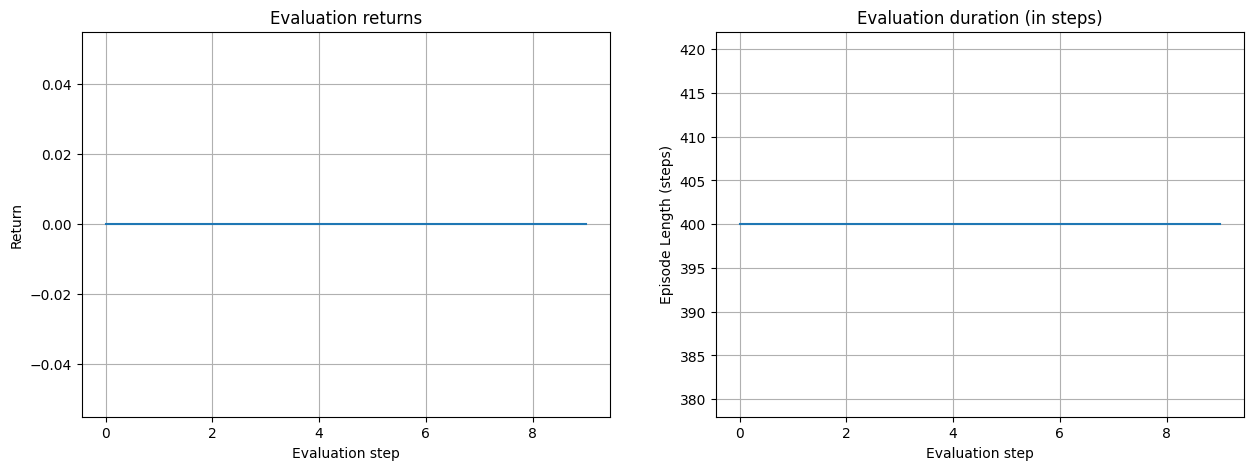

In [169]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(total_returns)
ax1.set_title('Evaluation returns')
ax1.set_xlabel('Evaluation step')
ax1.set_ylabel('Return')
ax1.grid(True)

ax2.plot(total_steps)
ax2.set_title('Evaluation duration (in steps)')
ax2.set_xlabel('Evaluation step')
ax2.set_ylabel('Episode Length (steps)')
ax2.grid(True)

In [77]:
env.close()

Saving the No-Fall policy and checkpoint

In [170]:
no_fall_policy_saver = policy_saver.PolicySaver(agent.policy)
no_fall_policy_saver.save('./saved_models/no_fall_agent')

# Save the entire agent state for continued training
checkpoint = tf.train.Checkpoint(
    q_net=agent._q_network,
    target_q_net=agent._target_q_network,
    optimizer=agent._optimizer,
    train_step=agent.train_step_counter
)
checkpoint.save('./checkpoints/no_fall_checkpoint')

INFO:tensorflow:Assets written to: ./saved_models/no_fall_agent/assets


/home/louay/miniforge3/envs/DQL_env/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: ./saved_models/no_fall_agent/assets


'./checkpoints/no_fall_checkpoint-1'

**2<sup>nd</sup> round of training**
During this round, the agent learns to collect good items (green spheres). We remove the red spheres from the environment and we change the rewards like this:
- Falling : -100
- Doing nothing : -5 (encouraging movement)
- Collecting green sphere : +50

Creating second agent with slightly different hyperparameters (for fine-tuning)

In [129]:
q_net = q_network.QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    fc_layer_params=(256, 512, 256, 128)
)

train_step_counter = tf.Variable(0)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter,
    epsilon_greedy=0.02,
    target_update_period=100,
    gamma=0.99
)

agent.initialize()

Restoring the No-Fall agent checkpoint

In [130]:
checkpoint = tf.train.Checkpoint(
    q_net=agent._q_network,
    target_q_net=agent._target_q_network,
    optimizer=agent._optimizer,
    train_step=agent.train_step_counter
)

checkpoint_path = checkpoint.restore('./checkpoints/no_fall_checkpoint-1')

Creating replay buffer for second round of training

In [104]:
stage2_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=100000
)

Setting up the new policies

In [131]:
eval_policy = agent.policy
collect_policy = agent.collect_policy
random_policy = random_tf_policy.RandomTFPolicy(
    tf_env.time_step_spec(), 
    tf_env.action_spec()
)

Initial data collection

In [114]:
stage2_replay_buffer.clear()

collect_data(eval_policy, 500, 5, stage2_replay_buffer)  # Collect some experiences from the No-Fall policy
collect_data(random_policy, 1000, 5, stage2_replay_buffer)

Collected 100 steps
Collected 200 steps
Collected 300 steps
Collected 400 steps
Collected 100 steps
Collected 200 steps
Collected 300 steps
Collected 400 steps
Collected 500 steps
Collected 600 steps
Collected 700 steps
Collected 800 steps
Collected 900 steps


The training loop

In [115]:
num_iterations = 8000
collect_steps_per_iteration = 2
batch_size = 64
eval_interval = 200
speed = 100

stage2_dataset = stage2_replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2
).prefetch(3)

stage2_iterator = iter(stage2_dataset)

In [116]:
stage2_train_losses = []
stage2_episode_returns = []

for iteration in range(num_iterations):
    collect_data(collect_policy, 
                collect_steps_per_iteration, 
                speed,
                stage2_replay_buffer)

    experience, _ = next(stage2_iterator)
    train_loss = agent.train(experience).loss
    
    training_step = agent.train_step_counter.numpy()

    # Evaluate progress
    if training_step % eval_interval == 0:
        print(f'Training step {training_step}: Loss = {train_loss:.4f} | Env step = {iteration * collect_steps_per_iteration}')
        stage2_train_losses.append(train_loss.numpy())
        
        engine_config_channel.set_configuration_parameters(time_scale=1)
        time_step = tf_env.reset()
        episode_return = 0.0
        steps_in_episode = 0
        spheres_collected = 0

        while not time_step.is_last():
            action_step = eval_policy.action(time_step)
            time_step = tf_env.step(action_step.action)
            episode_return += time_step.reward
            steps_in_episode += 1
            
        stage2_episode_returns.append(episode_return.numpy()[0])
        print(f'Episode Return: {episode_return.numpy()[0]:.2f}')

print('Training complete!')

Training step 10200: Loss = 3.9322 | Env step = 398
Episode Return: 50.00
Training step 10400: Loss = 63.2497 | Env step = 798
Episode Return: -100.00
Training step 10600: Loss = 5.3917 | Env step = 1198
Episode Return: 0.00
Training step 10800: Loss = 4.9053 | Env step = 1598
Episode Return: -100.00
Training step 11000: Loss = 3.5257 | Env step = 1998
Episode Return: -120.00
Training step 11200: Loss = 2.6830 | Env step = 2398
Episode Return: -100.00
Training step 11400: Loss = 16.2441 | Env step = 2798
Episode Return: -100.00
Training step 11600: Loss = 11.7937 | Env step = 3198
Episode Return: -100.00
Training step 11800: Loss = 4.7022 | Env step = 3598
Episode Return: -100.00
Training step 12000: Loss = 3.2641 | Env step = 3998
Episode Return: -100.00
Training step 12200: Loss = 4.3489 | Env step = 4398
Episode Return: -100.00
Training step 12400: Loss = 1.5620 | Env step = 4798
Episode Return: -100.00
Training step 12600: Loss = 0.7987 | Env step = 5198
Episode Return: -100.00
Tra

Visualizing training information

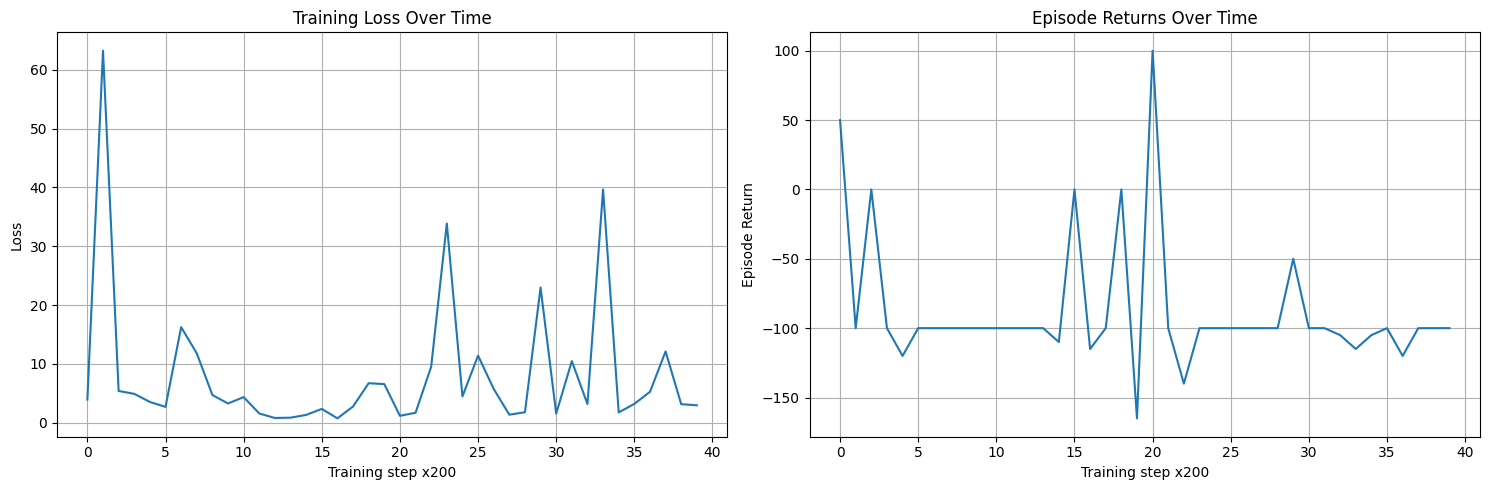

In [117]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(stage2_train_losses)
ax1.set_title('Training Loss Over Time')
ax1.set_xlabel('Training step x200')
ax1.set_ylabel('Loss')
ax1.grid(True)

ax2.plot(stage2_episode_returns)
ax2.set_title('Episode Returns Over Time')
ax2.set_xlabel('Training step x200')
ax2.set_ylabel('Episode Return')
ax2.grid(True)

plt.tight_layout()
plt.show()

Model evaluation

In [132]:
stage2_total_returns = []
stage2_total_steps = []

engine_config_channel.set_configuration_parameters(time_scale=3)
for episode in range(10):
    time_step = tf_env.reset()
    episode_return = 0.0
    steps_in_episode = 0

    while not time_step.is_last():
        action_step = eval_policy.action(time_step)
        time_step = tf_env.step(action_step.action)
        episode_return += time_step.reward
        steps_in_episode += 1
    
    stage2_total_returns.append(episode_return.numpy()[0])
    stage2_total_steps.append(steps_in_episode)
    print(f"Episode {episode+1}: Return = {episode_return.numpy()[0]:.2f}, Steps = {steps_in_episode}")

avg_return = np.mean(stage2_total_returns)
avg_steps = np.mean(stage2_total_steps)
std_return = np.std(stage2_total_returns)

print(f"Average Return: {avg_return:.2f}")
print(f"Average Episode Length: {avg_steps:.1f} steps")
print(f"Best Episode: {max(stage2_total_returns):.2f}")
print(f"Worst Episode: {min(stage2_total_returns):.2f}")

Episode 1: Return = 0.00, Steps = 400
Episode 2: Return = 50.00, Steps = 400
Episode 3: Return = 0.00, Steps = 400
Episode 4: Return = -100.00, Steps = 6
Episode 5: Return = 50.00, Steps = 400
Episode 6: Return = -100.00, Steps = 15
Episode 7: Return = 50.00, Steps = 400
Episode 8: Return = 0.00, Steps = 400
Episode 9: Return = 50.00, Steps = 400
Episode 10: Return = 0.00, Steps = 400
Average Return: 0.00
Average Episode Length: 322.1 steps
Best Episode: 50.00
Worst Episode: -100.00
